In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.4 MB/s eta 0:00:00


In [135]:
import torch as t
import einops
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from torch.autograd import grad
import os
from datetime import datetime

# Constants

In [3]:
P = 53
TRAIN_FRAC = 0.1
HIDDEN_SIZE = 128
LR = 0.01
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
BATCH_SIZE = 256
EMBED_DIM = 8

# Model architecture

In [4]:
class MLP(t.nn.Module):
    def __init__(self, embed_dim, vocab_size, hidden_dim, tie_unembed=False):
        super().__init__()
        self.embedding = t.nn.Embedding(vocab_size, embed_dim)
        self.linear1l, self.Linear1r = t.nn.Linear(embed_dim, hidden_dim, bias=True), t.nn.Linear(embed_dim, hidden_dim, bias=True)
        self.tie_unembed = tie_unembed
        if tie_unembed:
          self.linear2 = t.nn.Linear(hidden_dim, embed_dim, bias=True)
        else:
          self.linear2 = t.nn.Linear(hidden_dim, vocab_size, bias=True)
        self.gelu = t.nn.GELU()
        self.vocab_size = vocab_size

    def forward(self, x1, x2):
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x1 = self.linear1l(x1)
        x2 = self.linear1r(x2)
        x = x1 + x2
        x = self.gelu(x)
        x = self.linear2(x)
        if self.tie_unembed:
          x = x @ self.embedding.weight.T
        return x

### hard-coding complex multiplication

In [5]:
import torch.nn as nn

In [6]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


class ComplexMultiply(nn.Module):
    def __init__(self):
        super(ComplexMultiply, self).__init__()

    def forward(self, a, b):
        real_part = a[..., 0] * b[..., 0] - a[..., 1] * b[..., 1]
        imag_part = a[..., 0] * b[..., 1] + a[..., 1] * b[..., 0]
        return t.stack([real_part, imag_part], dim=-1)


### 2D MLP with hard-coded nonlinearity

In [7]:
class MLP_perfect(t.nn.Module):
    def __init__(self, vocab_size, tie_unembed=False, factor = 1):
        embed_dim = 2
        super().__init__()
        self.embedding = t.nn.Embedding(vocab_size, 2)
        self.factor = t.tensor(factor, dtype = t.float32).to(device)
        self.tie_unembed = tie_unembed
        if not tie_unembed:
          self.linear2 = t.nn.Linear(2, vocab_size, bias=True)
        self.cm = ComplexMultiply()
        self.vocab_size = vocab_size

    def forward(self, x1, x2):
        x1 = self.embedding(x1)*self.factor
        x2 = self.embedding(x2)*self.factor
        x = self.cm(x1, x2)
        if self.tie_unembed:
          x = x @ self.embedding.weight.T
        else:
          x = self.linear2(x)
        return x

# Make dataset

In [8]:
def get_all_pairs(p):
  pairs = []
  for i in range(p):
    for j in range(p):
      pairs.append((i,j))
  return set(pairs)

In [9]:
def make_dataset(p):
  data = []
  pairs = get_all_pairs(p)
  for a, b in pairs:
    data.append(((t.tensor(a), t.tensor(b)), t.tensor((a + b) % p)))
  return data


In [10]:
make_dataset(3)

[((tensor(0), tensor(1)), tensor(1)),
 ((tensor(1), tensor(2)), tensor(0)),
 ((tensor(2), tensor(1)), tensor(0)),
 ((tensor(0), tensor(0)), tensor(0)),
 ((tensor(1), tensor(1)), tensor(2)),
 ((tensor(2), tensor(0)), tensor(2)),
 ((tensor(0), tensor(2)), tensor(2)),
 ((tensor(2), tensor(2)), tensor(1)),
 ((tensor(1), tensor(0)), tensor(1))]

In [11]:
def train_test_split(dataset, train_split_proportion):
  l = len(dataset)
  train_len = int(train_split_proportion * l)
  idx = list(range(l))
  random.shuffle(idx)
  train_idx = idx[:train_len]
  test_idx = idx[train_len:]
  return [dataset[i] for i in train_idx], [dataset[i] for i in test_idx]

In [12]:
dataset = make_dataset(P)

In [13]:
train_data, test_data = train_test_split(dataset, TRAIN_FRAC)

In [14]:
len(train_data), len(test_data)

(561, 2248)

# Movies

In [ ]:
embeddings = model.embedding.weight.detach().cpu()
print(embeddings.size())
show_weights_modes(embeddings, identity=True, big=False)

In [71]:
cos = t.zeros((P, P))
sin = t.zeros((P, P))
for i in range(P):
    for j in range(P):
        theta = t.tensor(2 * t.pi * i * j / P)
        cos[i, j] = t.cos(theta)
        sin[i, j] = t.sin(theta)

def get_weights_modes(weights):
    c1 = cos @ (weights @ weights.T)
    s1 = sin @ (weights @ weights.T)
    return c1, s1

def ablate_other_modes(weights, modes):
    c1 = cos @ weights  # (vocab_size x vocab_size) x (vocab_size x embed_dim) = (vocab_size x embed_dim)
    s1 = sin @ weights  # (vocab_size x vocab_size) x (vocab_size x embed_dim) = (vocab_size x embed_dim)
    all_vecs = t.cat((c1[:P//2+1], s1[P//2+1:]), dim=0) # (vocab_size x embed_dim)
    modes = [0] + modes + [P - mode for mode in modes]  # (k,)
    a = all_vecs[modes] # (k x embed_dim)
    a_at = a @ a.T # (k x k)
    a_at_inv = t.linalg.inv(a_at) # (k x k)
    w = a.T @ a_at_inv @ a # (embed_dim x embed_dim)
    return weights @ w # (vocab_size x embed_dim)

In [125]:
def show_weights_modes(weights, title="Modes", identity=False, show = True, big = False):
    if identity == False:
        c1, s1 = get_weights_modes(weights)
    else:
        try:
            c1, s1 = weights.T[0,:], weights.T[1,:]
        except IndexError:
            c1, s1 = weights.T[:0], weights.T[:0]
    n_plots = (P // 2) + 1
    if big:
        num_cols = int(math.ceil(math.sqrt(n_plots)//2))
    else:
        num_cols = int(math.ceil(math.sqrt(n_plots)))
    num_rows = int(math.ceil(n_plots / num_cols))
    colormap = plt.cm.rainbow
    if big:
        plt.figure(figsize=(num_cols * 4, num_rows * 4))
    else:
        plt.figure(figsize=(num_cols * 2, num_rows * 2))
    colors = [colormap(i) for i in np.linspace(0, 1, P)]
    if identity == False:
        norms = []
    for mode in range(n_plots):
        if identity == False:
            cos = c1[mode]
            sin = s1[mode]
        else:
            cos = c1
            sin = s1
        plt.subplot(num_rows, num_cols, mode + 1)
        color_idx = [(i * mode) % P for i in range(P)]
        color_for_mode = [colors[idx] for idx in color_idx]
        if identity == False:
            avg_norm = sum([np.sqrt(cos[i]**2 + sin[i]**2) for i in range(len(cos))])
            norms.append(avg_norm)
        plt.scatter(cos.numpy(), sin.numpy(), c=color_for_mode)
#        plt.title(f"Mode {mode} {avg_norm:.4f}", fontsize=8)
        plt.title(f"Mode {mode}", fontsize=8)        
    plt.suptitle(title)
    norm = Normalize(vmin=0, vmax=P)
    sm = ScalarMappable(cmap=colormap, norm=norm)
    cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.01, 0.7])
    plt.colorbar(sm, cax=cbar_ax)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    if show:
        plt.show()

In [130]:
def plot_embeddings_movie(model, step):
    plt.clf()
    embeddings = model.embedding.weight.detach().cpu() # vocab_size x embed_dim
    #axs = axs.flatten()  # flatten the array of axes to simplify indexing
    show_weights_modes(embeddings, identity=True, show = False)    
    # make /frames if it does not exist
    if not os.path.exists("frames"):
        os.mkdir("frames")
    plt.savefig(f"frames/embeddings_movie_{step:06}.png") 
    plt.close()


In [127]:
def run_movie_cmd(suffix = ""):
    if not os.path.exists("movies"):
        os.mkdir("movies")
    mp4_name = os.path.join('movies', f'movie_{datetime.now().strftime("%Y%m%d_%H%M%S")}{suffix}.mp4')
    os.system(f'ffmpeg -framerate 3 -i frames/embeddings_movie_%06d.png -c:v libx264 -pix_fmt yuv420p {mp4_name}')
    os.system('rm frames/embeddings_movie_*.png')
    print(f'movie saved as {mp4_name}')

# Training

In [15]:
def test(model, dataset, device):
  n_correct = 0
  model.eval()
  with t.no_grad():
    for (x1, x2), y in dataset:
      out = model(x1.to(device), x2.to(device)).cpu()
      pred = t.argmax(out)
      if pred == y:
        n_correct += 1
  return n_correct / len(dataset)

In [139]:
def train(model, train_dataset, test_dataset, batch_size, lr, n_batches, device, save_frames = False):
  model = model.to(device)
  optimizer = t.optim.Adam(model.parameters(), weight_decay=0.0002, lr=lr)
  loss_fn = t.nn.CrossEntropyLoss()
  idx = list(range(len(train_dataset)))
  avg_loss = 0
  print_every = n_batches // 20
  step = 0
  for i in tqdm(range(n_batches)):
    model.train()
    # Sample random batch of data
    batch_idx = random.sample(idx, batch_size)
    X_1 = t.stack([train_dataset[b][0][0] for b in batch_idx]).to(device)
    X_2 = t.stack([train_dataset[b][0][1] for b in batch_idx]).to(device)
    Y = t.stack([train_dataset[b][1] for b in batch_idx]).to(device)
    # Gradient update
    optimizer.zero_grad()
    out = model(X_1, X_2)
    loss = loss_fn(out, Y)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      val_acc = test(model, test_dataset, device)
      avg_loss /= print_every
      print(f"Batch: {i} | Loss: {avg_loss} | Val Acc: {val_acc}")
      avg_loss = 0
    if save_frames:
        if i%30 == 0:
            with t.no_grad():
                step += 1
                plot_embeddings_movie(model, step)
    if i % print_every == 0:
      val_acc = test(model, test_dataset, device)
      avg_loss /= print_every
      print(f"Batch: {i} | Loss: {avg_loss} | Val Acc: {val_acc}")
      avg_loss = 0
  val_acc = test(model, test_dataset, device)
  print(f"Final Val Acc: {val_acc}")
  return model

In [141]:
model = MLP_perfect(vocab_size=P, factor = np.sqrt(P))
model = train(
    model=model,
    train_dataset=train_data,
    test_dataset=test_data,
    batch_size=BATCH_SIZE,
    lr=LR,
    n_batches = 2300,
    device = device,
    save_frames = True
  )
run_movie_cmd()

  0%|                                                  | 0/2300 [00:00<?, ?it/s]

Batch: 0 | Loss: 0.47086835114852243 | Val Acc: 0.018683274021352312


/tmp/ipykernel_37037/3132434107.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
  0%|                                        | 1/2300 [00:03<2:18:20,  3.61s/it]

Batch: 0 | Loss: 0.0 | Val Acc: 0.018683274021352312


  4%|█▌                                       | 91/2300 [00:13<04:41,  7.84it/s]

Batch: 115 | Loss: 13.610892557061236 | Val Acc: 0.02224199288256228


  5%|██                                      | 116/2300 [00:14<03:19, 10.95it/s]

Batch: 115 | Loss: 0.0 | Val Acc: 0.02224199288256228


  9%|███▋                                    | 211/2300 [00:26<03:48,  9.16it/s]

Batch: 230 | Loss: 3.8735424269800602 | Val Acc: 0.02224199288256228


 10%|████                                    | 231/2300 [00:26<03:04, 11.22it/s]

Batch: 230 | Loss: 0.0 | Val Acc: 0.02224199288256228


 14%|█████▊                                  | 331/2300 [00:38<03:25,  9.57it/s]

Batch: 345 | Loss: 3.7954712971397067 | Val Acc: 0.02179715302491103


 15%|██████                                  | 346/2300 [00:39<02:59, 10.91it/s]

Batch: 345 | Loss: 0.0 | Val Acc: 0.02179715302491103


 20%|███████▊                                | 451/2300 [00:51<03:10,  9.71it/s]

Batch: 460 | Loss: 3.7636660555134647 | Val Acc: 0.02090747330960854


 20%|████████                                | 461/2300 [00:51<02:57, 10.35it/s]

Batch: 460 | Loss: 0.0 | Val Acc: 0.02090747330960854


 25%|█████████▉                              | 571/2300 [01:03<02:56,  9.81it/s]

Batch: 575 | Loss: 3.7077782050423 | Val Acc: 0.026690391459074734


 25%|██████████                              | 576/2300 [01:03<02:57,  9.74it/s]

Batch: 575 | Loss: 0.0 | Val Acc: 0.026690391459074734


 29%|███████████▍                            | 661/2300 [01:12<02:41, 10.17it/s]

Batch: 690 | Loss: 3.624275939360909 | Val Acc: 0.03291814946619217


 30%|████████████                            | 691/2300 [01:15<02:47,  9.63it/s]

Batch: 690 | Loss: 0.0 | Val Acc: 0.03291814946619217


 34%|█████████████▌                          | 781/2300 [01:25<02:38,  9.61it/s]

Batch: 805 | Loss: 3.356055966667507 | Val Acc: 0.0645017793594306


 35%|██████████████                          | 806/2300 [01:25<02:05, 11.94it/s]

Batch: 805 | Loss: 0.0 | Val Acc: 0.0645017793594306


 39%|███████████████▋                        | 901/2300 [01:37<02:26,  9.57it/s]

Batch: 920 | Loss: 2.5849140934322192 | Val Acc: 0.18149466192170818


 40%|████████████████                        | 921/2300 [01:38<01:59, 11.57it/s]

Batch: 920 | Loss: 0.0 | Val Acc: 0.18149466192170818


 44%|█████████████████▎                     | 1021/2300 [01:50<02:17,  9.30it/s]

Batch: 1035 | Loss: 1.8215108964754188 | Val Acc: 0.3474199288256228


 45%|█████████████████▌                     | 1036/2300 [01:51<01:59, 10.62it/s]

Batch: 1035 | Loss: 0.0 | Val Acc: 0.3474199288256228


 50%|███████████████████▎                   | 1141/2300 [02:03<02:05,  9.22it/s]

Batch: 1150 | Loss: 1.4589235606400863 | Val Acc: 0.3919039145907473


 50%|███████████████████▌                   | 1151/2300 [02:04<01:56,  9.86it/s]

Batch: 1150 | Loss: 0.0 | Val Acc: 0.3919039145907473


 55%|█████████████████████▍                 | 1261/2300 [02:17<01:54,  9.06it/s]

Batch: 1265 | Loss: 1.2482494167659595 | Val Acc: 0.5155693950177936


 55%|█████████████████████▍                 | 1266/2300 [02:17<01:54,  9.06it/s]

Batch: 1265 | Loss: 0.0 | Val Acc: 0.5155693950177936


 59%|██████████████████████▉                | 1351/2300 [02:27<01:41,  9.36it/s]

Batch: 1380 | Loss: 1.1181380883507106 | Val Acc: 0.49466192170818507


 60%|███████████████████████▍               | 1381/2300 [02:30<01:41,  9.03it/s]

Batch: 1380 | Loss: 0.0 | Val Acc: 0.49466192170818507


 64%|████████████████████████▉              | 1471/2300 [02:39<01:26,  9.62it/s]

Batch: 1495 | Loss: 0.997721004486084 | Val Acc: 0.625


 65%|█████████████████████████▎             | 1496/2300 [02:40<01:06, 12.08it/s]

Batch: 1495 | Loss: 0.0 | Val Acc: 0.625


 69%|██████████████████████████▉            | 1591/2300 [02:53<01:21,  8.67it/s]

Batch: 1610 | Loss: 0.9088312983512878 | Val Acc: 0.6770462633451957


 70%|███████████████████████████▎           | 1611/2300 [02:53<01:05, 10.45it/s]

Batch: 1610 | Loss: 0.0 | Val Acc: 0.6770462633451957


 74%|█████████████████████████████          | 1711/2300 [03:05<01:02,  9.42it/s]

Batch: 1725 | Loss: 0.8372765105703602 | Val Acc: 0.6792704626334519


 75%|█████████████████████████████▎         | 1726/2300 [03:06<00:53, 10.75it/s]

Batch: 1725 | Loss: 0.0 | Val Acc: 0.6792704626334519


 80%|███████████████████████████████        | 1831/2300 [03:18<00:48,  9.69it/s]

Batch: 1840 | Loss: 0.7572682904160541 | Val Acc: 0.6272241992882562


 80%|███████████████████████████████▏       | 1841/2300 [03:18<00:44, 10.22it/s]

Batch: 1840 | Loss: 0.0 | Val Acc: 0.6272241992882562


 85%|█████████████████████████████████      | 1951/2300 [03:30<00:36,  9.63it/s]

Batch: 1955 | Loss: 0.6970932794653851 | Val Acc: 0.7104092526690391


 85%|█████████████████████████████████▏     | 1956/2300 [03:31<00:36,  9.51it/s]

Batch: 1955 | Loss: 0.0 | Val Acc: 0.7104092526690391


 89%|██████████████████████████████████▌    | 2041/2300 [03:41<00:29,  8.90it/s]

Batch: 2070 | Loss: 0.6388958905054175 | Val Acc: 0.8002669039145908


 90%|███████████████████████████████████    | 2071/2300 [03:45<00:26,  8.62it/s]

Batch: 2070 | Loss: 0.0 | Val Acc: 0.8002669039145908


 94%|████████████████████████████████████▋  | 2161/2300 [03:54<00:14,  9.66it/s]

Batch: 2185 | Loss: 0.5887254896371261 | Val Acc: 0.7468861209964412


 95%|█████████████████████████████████████  | 2186/2300 [03:54<00:09, 12.19it/s]

Batch: 2185 | Loss: 0.0 | Val Acc: 0.7468861209964412


100%|███████████████████████████████████████| 2300/2300 [04:06<00:00,  9.32it/s]


Final Val Acc: 0.8104982206405694


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

movie saved as movies/movie_20231003_215939.mp4


frame=   77 fps= 30 q=-1.0 Lsize=    2529kB time=00:00:24.66 bitrate= 839.9kbits/s speed=9.45x    
video:2527kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.068396%
[libx264 @ 0x56367176f440] frame I:1     Avg QP:11.30  size:132759
[libx264 @ 0x56367176f440] frame P:26    Avg QP:14.90  size: 58570
[libx264 @ 0x56367176f440] frame B:50    Avg QP:22.37  size: 18632
[libx264 @ 0x56367176f440] consecutive B-frames: 10.4%  7.8%  3.9% 77.9%
[libx264 @ 0x56367176f440] mb I  I16..4: 53.5%  1.0% 45.5%
[libx264 @ 0x56367176f440] mb P  I16..4:  3.7%  0.4%  1.9%  P16..4: 14.9%  9.7% 10.4%  0.0%  0.0%    skip:59.1%
[libx264 @ 0x56367176f440] mb B  I16..4:  0.2%  0.2%  0.1%  B16..8: 17.8%  7.2%  5.0%  direct: 3.0%  skip:66.6%  L0:42.5% L1:37.9% BI:19.6%
[libx264 @ 0x56367176f440] 8x8 transform intra:7.6% inter:9.6%
[libx264 @ 0x56367176f440] coded y,uvDC,uvAC intra: 23.8% 29.2% 27.3% inter: 9.7% 15.3% 14.3%
[libx264 @ 0x56367176f440] i16 v,h,dc,p: 77% 20%  3%  0%
[l

<Figure size 640x480 with 0 Axes>

# Fourier transform

In [ ]:
c, s = get_weights_modes(model.embedding.weight.detach().cpu())

In [ ]:
mags = t.sqrt((c**2 + s**2).mean(dim=-1))

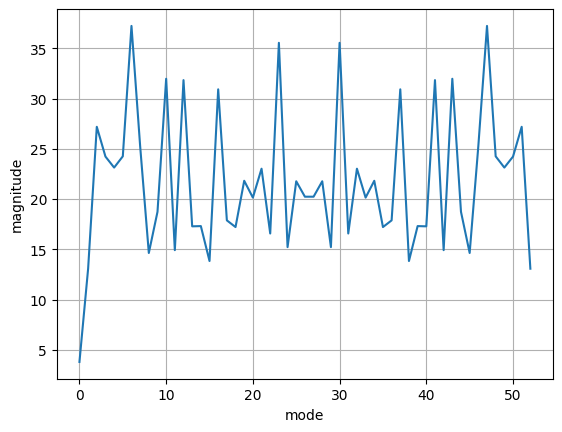

In [ ]:
plt.plot(mags)
plt.xlabel("mode")
plt.ylabel("magnitude")
plt.grid()
plt.show()

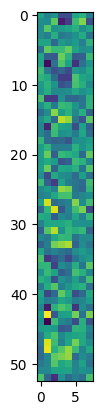

In [ ]:
plt.imshow(ablate_other_modes(model.embedding.weight.detach().cpu(), [6]))

<ipython-input-17-1826daf31b27>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


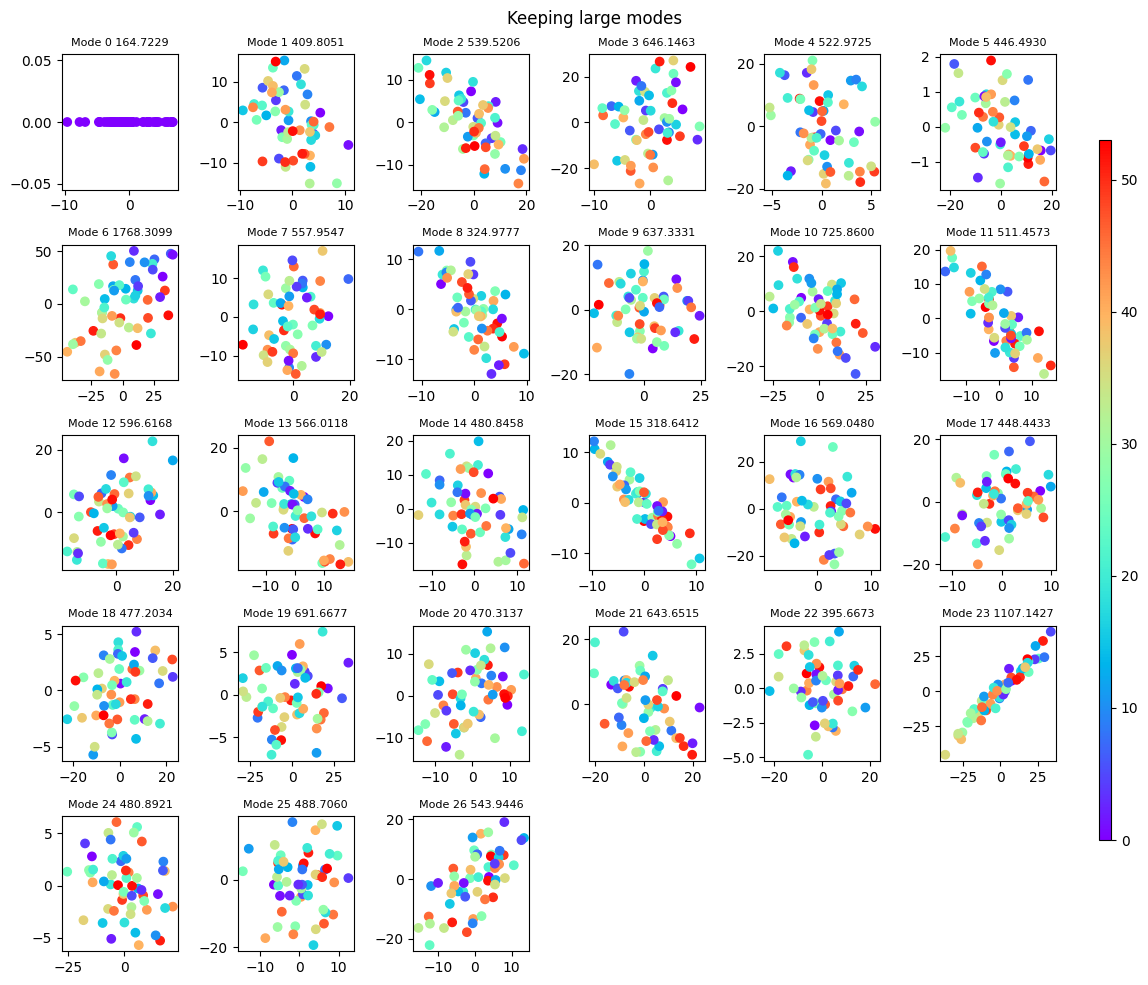

In [ ]:
ablated = ablate_other_modes(model.embedding.weight.detach().cpu(), [6])
show_weights_modes(ablated, title="Keeping large modes")

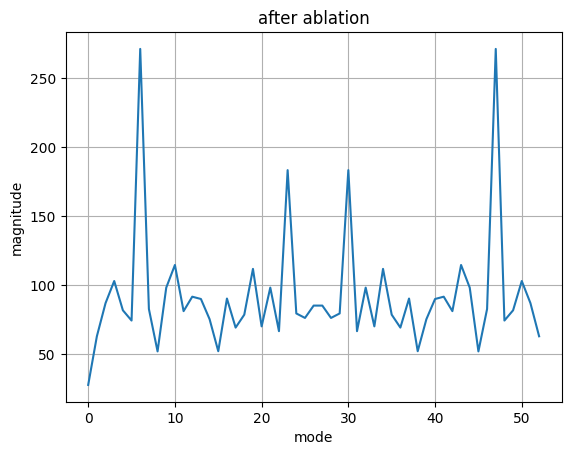

In [ ]:
c, s = get_weights_modes(ablated)
mags = t.sqrt((c**2 + s**2).sum(dim=-1))
plt.plot(mags)
plt.xlabel("mode")
plt.ylabel("magnitude")
plt.title("after ablation")
plt.grid()
plt.show()

In [ ]:
def eval_model(model, dataset, device):
  model.eval()
  avg_loss = 0
  loss_fn = t.nn.CrossEntropyLoss()
  with t.no_grad():
    for (x1, x2), y in dataset:
      out = model(x1.to(device), x2.to(device)).cpu()
      avg_loss += loss_fn(out, y)
  return avg_loss / len(dataset)

In [ ]:
def get_loss_only_modes(model, modes, test_dataset, device, embed_dim=EMBED_DIM, vocab_size=P, hidden_dim=HIDDEN_SIZE, tie_unembed=False):
  model_copy = MLP(embed_dim=embed_dim, vocab_size=vocab_size, hidden_dim=hidden_dim, tie_unembed=tie_unembed)
  model_copy.to(device)
  model_copy.load_state_dict(model.state_dict())
  model_copy.eval()
  model_copy.embedding.weight.data = ablate_other_modes(model_copy.embedding.weight.detach().cpu(), modes).to(device)
  return eval_model(model_copy, test_dataset, device).item()

In [ ]:
eval_model(model, test_data, device)

tensor(9.6353)

In [ ]:
# get_loss_only_modes(model, list(range(1, P//2)), test_data, device)

In [ ]:
get_loss_only_modes(model, [6, 3, 1], test_data, device)

9.446537971496582

In [ ]:
def get_magnitude_modes(weights):
    c1, s1 = cos @ weights, sin @ weights
    return t.sqrt(t.sum(c1**2 + s1**2, dim=-1))

In [ ]:
x = get_magnitude_modes(model.embedding.weight.detach().cpu())
x.shape

torch.Size([53])

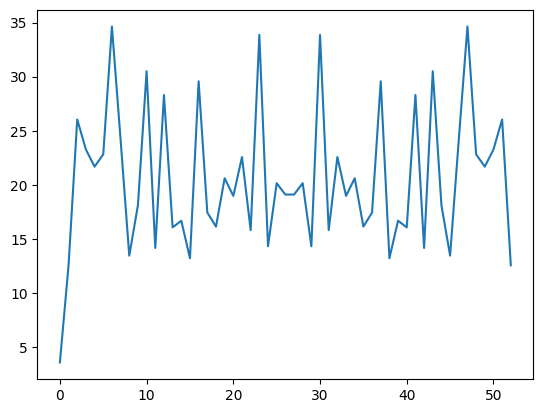

In [ ]:
plt.figure()
plt.plot(x)
plt.show()

# Train keeping track of individual mode suspace's loss

In [ ]:
hidden_dim = 64 # Use larger hidden dim when freezing layer

In [ ]:
def train_with_modes(model, train_dataset, test_dataset, batch_size, lr, n_batches, device, freeze=True, tie_unembed=False):
  model = model.to(device)
  if freeze:
    optimizer = t.optim.Adam(list(model.embedding.parameters()) + list(model.linear2.parameters()), weight_decay=0, lr=lr)
  else:
    optimizer = t.optim.Adam(model.parameters(), weight_decay=0, lr=lr)
  loss_fn = t.nn.CrossEntropyLoss()
  idx = list(range(len(train_dataset)))
  avg_loss = 0
  track_every = n_batches // 20
  print_every = n_batches // 10
  mode_loss_history = []
  magnitude_history = []
  for i in tqdm(range(n_batches)):
    model.eval()
    with t.no_grad():
      if i % track_every == 0:
        mode_losses = {}
        mags = get_magnitude_modes(model.embedding.weight.detach().cpu())
        magnitude_history.append(mags)
        for mode in range(1, P//2 + 1):
          l_mode = get_loss_only_modes(model, [mode], test_dataset, device, hidden_dim=hidden_dim, tie_unembed=tie_unembed)
          mode_losses[mode] = l_mode
        mode_loss_history.append(mode_losses)
      if i % print_every == 0:
          val_acc = test(model, test_dataset, device)
          avg_loss /= print_every
          print(f"Batch: {i} | Loss: {avg_loss} | Val Acc: {val_acc}")
          avg_loss = 0
    model.train()
    # Sample random batch of data
    batch_idx = random.sample(idx, batch_size)
    X_1 = t.stack([train_dataset[b][0][0] for b in batch_idx]).to(device)
    X_2 = t.stack([train_dataset[b][0][1] for b in batch_idx]).to(device)
    Y = t.stack([train_dataset[b][1] for b in batch_idx]).to(device)
    # Gradient update
    optimizer.zero_grad()
    out = model(X_1, X_2)
    loss = loss_fn(out, Y)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
  val_acc = test(model, test_dataset, device)
  print(f"Final Val Acc: {val_acc}")
  return model, mode_loss_history, magnitude_history


In [ ]:
l = test_data
random.shuffle(l)
l = l[:200]

In [ ]:
model = MLP(embed_dim=EMBED_DIM, vocab_size=P, hidden_dim=hidden_dim, tie_unembed=True)
model, mode_loss_history, magnitude_history = train_with_modes(
    model=model,
    train_dataset=train_data,
    test_dataset=l,
    batch_size=BATCH_SIZE,
    lr=0.02,
    n_batches = 1000,
    device = device,
    freeze = True,
    tie_unembed=True
  )

  4%|▎         | 35/1000 [00:02<00:45, 21.18it/s]

Batch: 0 | Loss: 0.0 | Val Acc: 0.02


 14%|█▍        | 139/1000 [00:06<00:32, 26.37it/s]

Batch: 100 | Loss: 3.5295003247261048 | Val Acc: 0.035


 23%|██▎       | 234/1000 [00:12<00:32, 23.72it/s]

Batch: 200 | Loss: 2.6599068093299865 | Val Acc: 0.085


 34%|███▎      | 336/1000 [00:16<00:24, 26.96it/s]

Batch: 300 | Loss: 1.5633123725652696 | Val Acc: 0.27


 44%|████▍     | 443/1000 [00:21<00:19, 28.84it/s]

Batch: 400 | Loss: 0.5099564708769322 | Val Acc: 0.455


 55%|█████▌    | 550/1000 [00:26<00:16, 27.16it/s]

Batch: 500 | Loss: 0.1498208549618721 | Val Acc: 0.485


 63%|██████▎   | 630/1000 [00:30<00:15, 23.76it/s]

Batch: 600 | Loss: 0.05406476616859436 | Val Acc: 0.485


 73%|███████▎  | 726/1000 [00:35<00:12, 21.98it/s]

Batch: 700 | Loss: 0.027334951609373093 | Val Acc: 0.49


 82%|████████▏ | 818/1000 [00:40<00:09, 18.31it/s]

Batch: 800 | Loss: 0.016464981362223626 | Val Acc: 0.475


 94%|█████████▎| 937/1000 [00:45<00:02, 23.22it/s]

Batch: 900 | Loss: 0.011132744904607535 | Val Acc: 0.475


100%|██████████| 1000/1000 [00:48<00:00, 20.49it/s]


Final Val Acc: 0.465


<ipython-input-17-1826daf31b27>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


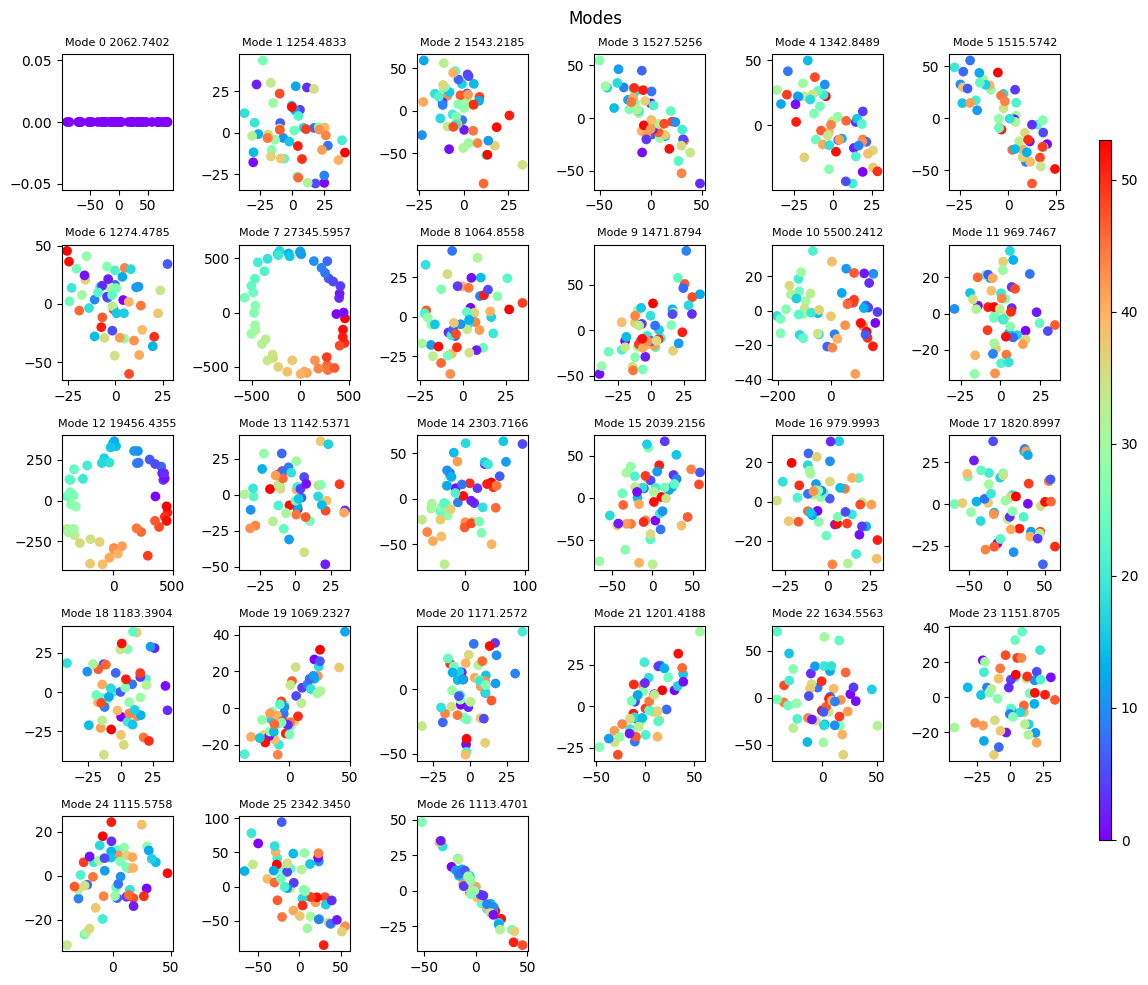

In [ ]:
show_weights_modes(model.embedding.weight.detach().cpu())

In [ ]:
get_loss_only_modes(model, [17, 3], test_data, device, hidden_dim=hidden_dim, tie_unembed=True)

19.2725887298584

In [ ]:
eval_model(model, test_data, device)

tensor(3.9365)

In [ ]:
import matplotlib.cm as cm

<ipython-input-42-3570a3dd90a4>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("rainbow", num_plots)


<Figure size 640x480 with 0 Axes>

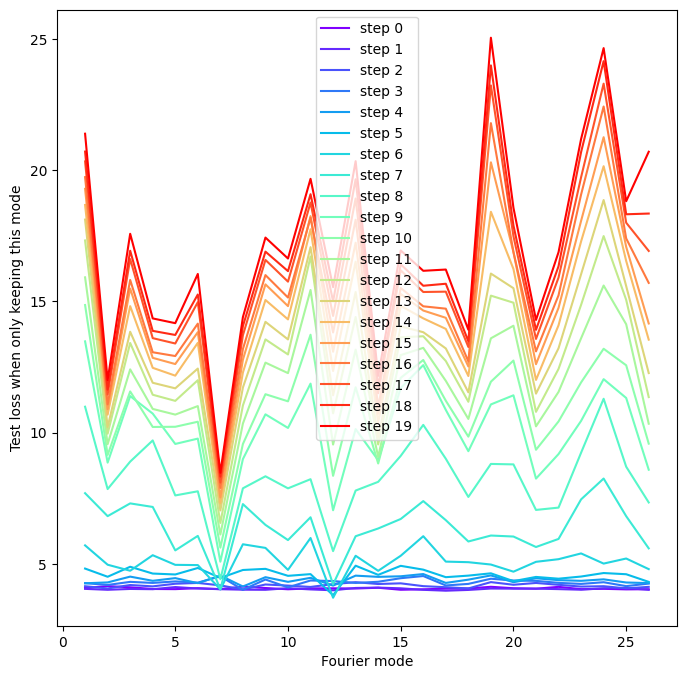

In [ ]:
plt.clf()
plt.figure(figsize=(8, 8))
num_plots = len(mode_loss_history)
colormap = cm.get_cmap("rainbow", num_plots)

for idx, history in enumerate(mode_loss_history):
    color = colormap(idx)
    plt.plot(list(history.keys()), list(history.values()), color=color, label=f"step {idx}")
plt.xlabel("Fourier mode")
plt.ylabel("Test loss when only keeping this mode")
plt.legend()
plt.show()

<ipython-input-43-7bf6c3d6078e>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("rainbow", num_plots)


<Figure size 640x480 with 0 Axes>

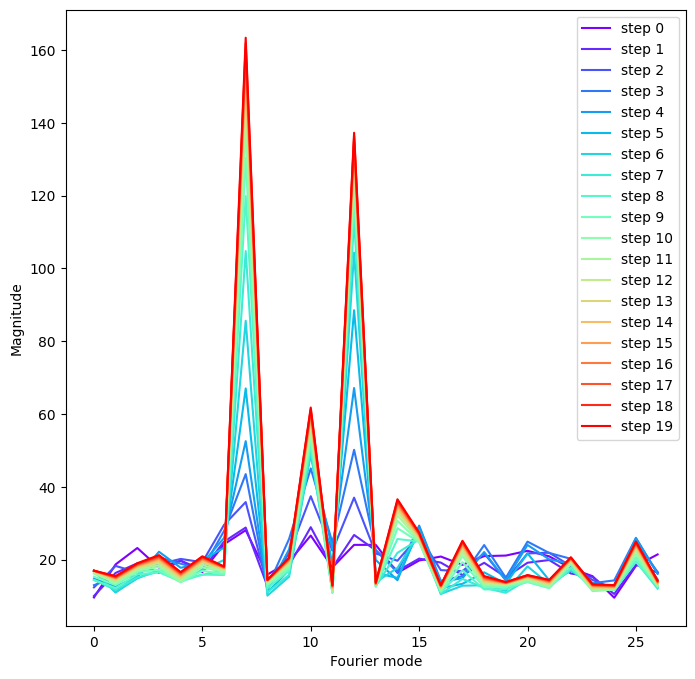

In [ ]:
plt.clf()
plt.figure(figsize=(8, 8))
num_plots = len(magnitude_history)
colormap = cm.get_cmap("rainbow", num_plots)

for idx, history in enumerate(magnitude_history):
    color = colormap(idx)
    plt.plot(list(history)[:P//2 + 1], color=color, label=f"step {idx}")
plt.xlabel("Fourier mode")
plt.ylabel("Magnitude")
plt.legend()
plt.show()